<img align="left" src = https://noirlab.edu/public/media/archives/logos/svg/logo250.svg width=250 style="background-color:white; padding:10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">

Contact author(s): Andrés A. Plazas Malagón <br>
Last verified to run: 2025-2-25 <br>
LSST Science Pipelines version: Weekly 2024_50 <br>
Container Size: small <br>

In [3]:
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np

import lsst.afw.cameraGeom.utils as camGeomUtils
from lsst.afw.cameraGeom import Detector, PIXELS, FOCAL_PLANE
from lsst.geom import Box2D, Point2D

from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()

In [72]:
# Define bad amplifier segments.
# These segments are specified as "DetectorName_without_prefix" + "_" + amplifier number.
#Taken from Tables 8 and 9 of SITCOMTN-148.
non_functional_segs = {
    "dead": [
        "R30_S00_C10",
        "R01_S01_C00",
        "R03_S11_C00",
        "R04_SG0_C11"
    ],
    "hi_noise": [
        "R41_S21_C02",
        "R43_S20_C14",
        "R03_S01_C05",
        "R40_SG1_C10",
        "R44_SG0_C02"
    ]
}

###############################################################################
# Helper functions

def get_raft_and_sensor(detector):
    """
    Parse the detector name to extract raft and sensor names.
    For example, "R04_SW0" → raft "R04" and sensor "SW0".
    """
    detName = detector.getName()
    match = re.match(r'^(R\d{2})_([A-Z0-9]+)$', detName)
    if match:
        return match.group(1), match.group(2)
    else:
        parts = detName.split('_')
        if len(parts) >= 2:
            return parts[0], parts[1]
        return detName, None

def get_sensor_color(det):
    """
    Determine a color for a detector based on its physical type.
    Uses LSST’s detector information (e.g., ITL vs. e2v).
    """
    ptype = det.getPhysicalType()  # e.g., "ITL_WF", "ITL_SCIENCE", "e2v", etc.
    if ptype == "ITL":
        return "#D55E00"  # vermillion for ITL
    elif ptype == "E2V":
        return "#0072B2"  # blue for e2v
    elif ptype == "ITL_G":
        return "#CC79A7"  # purple for guider
    elif ptype == "ITL_WF":
        return "#009E73"  # green for wavefront (if not already caught above)
    else:
        return "#000000"

def get_focal_plane_bbox(detector):
    """
    Compute the bounding box of a detector (CCD) in focal-plane coordinates (mm).
    """
    corners = detector.getCorners(camGeomUtils.FOCAL_PLANE)
    xs = [pt.getX() for pt in corners]
    ys = [pt.getY() for pt in corners]
    return Box2D(Point2D(min(xs), min(ys)), Point2D(max(xs), max(ys)))

def plot_box(ax, box, edgecolor='black', linewidth=1, linestyle='-'):
    """
    Draw a rectangular patch defined by an lsst.geom.Box2D onto the given Axes.
    """
    min_pt = box.getMin()
    max_pt = box.getMax()
    width = max_pt.getX() - min_pt.getX()
    height = max_pt.getY() - min_pt.getY()
    rect = patches.Rectangle((min_pt.getX(), min_pt.getY()),
                             width, height,
                             edgecolor=edgecolor,
                             facecolor='none',
                             linewidth=linewidth,
                             linestyle=linestyle)
    ax.add_patch(rect)


In [73]:



###############################################################################
# Main plotting function

def plot_lsst_focal_plane():
    """
    Plot the LSSTCam focal plane using LSST stack functions.
    
    - Detectors are grouped by raft (extracted from detector names).
    - Each CCD is subdivided into its 16 amplifier regions.
    - Non-functional amplifiers (from the global non_functional amps list) are 
      filled with black and hatched.
    - Each CCD is labeled in the upper left with its sensor name
      (e.g. "S20" or "SW0")
      on the first line and its detector ID on the second.
    - A legend is added to explain CCD types.
    """
    # Group detectors by raft.
    raft_dict = {}
    for det in camera:
        raft, sensor = get_raft_and_sensor(det)
        raft_dict.setdefault(raft, []).append(det)
    
    # Initialize aggregated bounding boxes.
    itl_bbox = None
    e2v_bbox = None
    fp_bbox_total = None
    
    mpl.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Loop over each raft.
    for raft, detList in raft_dict.items():
        # Use the color of the first detector in the raft.
        raft_color = get_sensor_color(detList[0])
        # Compute the union bounding box for the raft.
        raft_bbox = None
        for det in detList:
            bbox = get_focal_plane_bbox(det)
            if raft_bbox is None:
                raft_bbox = bbox
            else:
                raft_bbox.include(bbox)
        if fp_bbox_total is None:
            fp_bbox_total = raft_bbox
        else:
            fp_bbox_total.include(raft_bbox)
        # Update aggregated ITL and e2v regions.
        for det in detList:
            ptype = det.getPhysicalType()
            bbox = get_focal_plane_bbox(det)
            if "ITL" in ptype:
                if itl_bbox is None:
                    itl_bbox = bbox
                else:
                    itl_bbox.include(bbox)
            elif "e2v" in ptype:
                if e2v_bbox is None:
                    e2v_bbox = bbox
                else:
                    e2v_bbox.include(bbox)
        # Draw the raft outline.
        plot_box(ax, raft_bbox, edgecolor=raft_color, linewidth=2,
                 linestyle='-')
        if raft == "R00":
            offset_x, offset_y = -25, -25
        elif raft == "R04":
            offset_x, offset_y = 25, -25
        elif raft == "R40":
            offset_x, offset_y = -25, 25
        elif raft == "R44":
            offset_x, offset_y = 25, 25
        else:
            offset_x, offset_y = 0, 0
        # Label the raft (centered) in black.
        raft_center = raft_bbox.getCenter()
        #print (raft, raft_center.getX() , raft_center.getY())
        ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, raft,
                color='black', fontsize=14, ha='center', va='center')
        
        # Loop over each sensor (CCD) in the raft.
        for det in detList:
            sensor_bbox = get_focal_plane_bbox(det)
            det_color = get_sensor_color(det)
            plot_box(ax, sensor_bbox, edgecolor=det_color, linewidth=0.5, linestyle='-')
            # Label the sensor in the upper-left: show only the sensor name and ID.
            _, sensor_name = get_raft_and_sensor(det)
            label_x = sensor_bbox.getMin().getX() + 2
            label_y = sensor_bbox.getMax().getY() - 2
            det_id = det.getId()
            label = f"{sensor_name} ({det_id})"

            # For labels in corner, use raft coordinate system to avoid overlaps.
            if det_id == 189:
                label = f"{sensor_name}\n({det_id})"
                offset_x = -5
                offset_y = -10
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=6, ha='center', va='center')
            elif det_id == 201:
                label = f"{sensor_name}\n({det_id})"
                offset_x = 6
                offset_y = 11
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=6, ha='center', va='center')
            elif det_id == 198:
                label = f"{sensor_name}\n({det_id})"
                offset_x = -5
                offset_y = 11
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=6, ha='center', va='center')
            elif det_id == 199:
                label = f"{sensor_name} ({det_id})"
                offset_x = 8
                offset_y = 0
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=3.6, ha='center', va='center')
            elif det_id == 200:
                label = f"{sensor_name} ({det_id})"
                offset_x = 31
                offset_y = 0
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=3.6, ha='center', va='center')
            elif det_id == 194:
                label = f"{sensor_name}\n({det_id})"
                offset_x = 6
                offset_y = -11
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=6, ha='center', va='center')
            elif det_id == 195:
                label = f"{sensor_name} ({det_id})"
                offset_x = -31
                offset_y = -1
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=3.6, ha='center', va='center')
            elif det_id == 196:
                label = f"{sensor_name} ({det_id})"
                offset_x = -4
                offset_y = -1
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=3.6, ha='center', va='center')
            else:
                ax.text(label_x, label_y, label,
                        color='black', fontsize=6, ha='left', va='top')
                label = f"{sensor_name} ({det_id})"
            
            # --- Subdivide the sensor into 16 amplifier regions ---
            
            transform = det.getTransform(PIXELS, FOCAL_PLANE)
            amps = list(det)
            if amps:
                # Determine pixel size from the first amplifier.
                amp_bbox0 = amps[0].getBBox()
                dx = amp_bbox0.getWidth()
                dy = amp_bbox0.getHeight()
                # Loop over amplifiers; assume names like "C00", "C01", etc.
                for amp in det:
                    # use BBox of the Amp to get the corners
                    bbox = amp.getBBox()
                    llcorner = bbox.getCorners()[0]
                    urcorner = bbox.getCorners()[2]
                    
                    p0 = transform.applyForward(Point2D(llcorner.getX(),llcorner.getY()))
                    p1 = transform.applyForward(Point2D(urcorner.getX(),urcorner.getY()))
                    
                    # Construct full amplifier ID as "DetectorName_ampName"
                    full_amp_id = f"{det.getName()}_{amp.getName()}"

                    if full_amp_id in non_functional_segs["dead"]:
                        facecolor = 'black'
                        hatch = None
                    elif full_amp_id in non_functional_segs["hi_noise"]:
                        facecolor = 'gray'
                        hatch = '///'
                    else:
                        facecolor = 'none'
                        hatch = None
                    
                    rect = patches.Rectangle((p0.getX(), p0.getY()),
                                             p1.getX() - p0.getX(),
                                             p1.getY() - p0.getY(),
                                             edgecolor=det_color,
                                             facecolor=facecolor,
                                             linewidth=0.4,
                                             linestyle='-',
                                             hatch=hatch)


                    # Add amp names
                    # Skip labeling amps if raft=R22, sensor=S11 (ID=94).
                    if not (raft == 'R22' and sensor_name == 'S11' and det_id == 94):
                        # Only label amps in the central raft (R22) and corner rafts
                        if raft == "R22" or raft in ["R00", "R04", "R40", "R44"]:
                            rotation=90
                            amp_name_pos_x = p0.getX() + (p1.getX() - p0.getX())/2. - 0.75
                            amp_name_pos_y = p0.getY() + (p1.getY() - p0.getY())/2.
                            if det.getName() in ["R00_SG0", "R04_SW0", "R04_SW1", \
                                                 "R04_SG1", "R40_SW0", "R40_SW1", \
                                                 "R40_SG1", "R44_SG0"]:
                                rotation=0
                                amp_name_pos_x -= 2.25
                                amp_name_pos_y += 1.25
                                   
                            ax.text(amp_name_pos_x,amp_name_pos_y, 
                                    amp.getName(), color=det_color, 
                                    fontsize=4, ha='left', va='top', 
                                    rotation=rotation)
                    ax.add_patch(rect)
                
    
    # Adjust plot limits.
    if fp_bbox_total is not None:
        margin = 10.0  # mm
        min_pt = fp_bbox_total.getMin()
        max_pt = fp_bbox_total.getMax()
        ax.set_xlim(min_pt.getX() - margin, max_pt.getX() + margin)
        ax.set_ylim(min_pt.getY() - margin, max_pt.getY() + margin)
    
    # Publication-quality axis labels and ticks.
    ax.set_title("LSST Camera Focal Plane Layout", fontsize=16)
    ax.set_xlabel("Focal Plane X (mm)", fontsize=14)
    ax.set_ylabel("Focal Plane Y (mm)", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_aspect('equal', 'box')
    ax.grid(False)
    
    # Create a legend.
    import matplotlib.patches as mpatches
    legend_handles = [
        mpatches.Patch(color="#D55E00", label="ITL"),
        mpatches.Patch(color="#0072B2", label="e2v"),
        mpatches.Patch(color="#CC79A7", label="Guider"),
        mpatches.Patch(color="#009E73", label="Wavefront"),
        mpatches.Patch(color='black', label="Non-functional segment:\n dead"),
        mpatches.Patch(facecolor='gray', hatch="///",
                       label="Non-functional segment:\nhigh noise")
    ]
    ax.legend(handles=legend_handles, loc='upper right', 
              fontsize=5.62, ncol=2)
    #plt.savefig("LSST_focal_plane.png", dpi=300)
    plt.savefig("LSSTCam_focal_plane_andres_2025MAR03.pdf", bbox_inches='tight')
    plt.show()

# To use, simply call:
# plot_lsst_focal_plane()


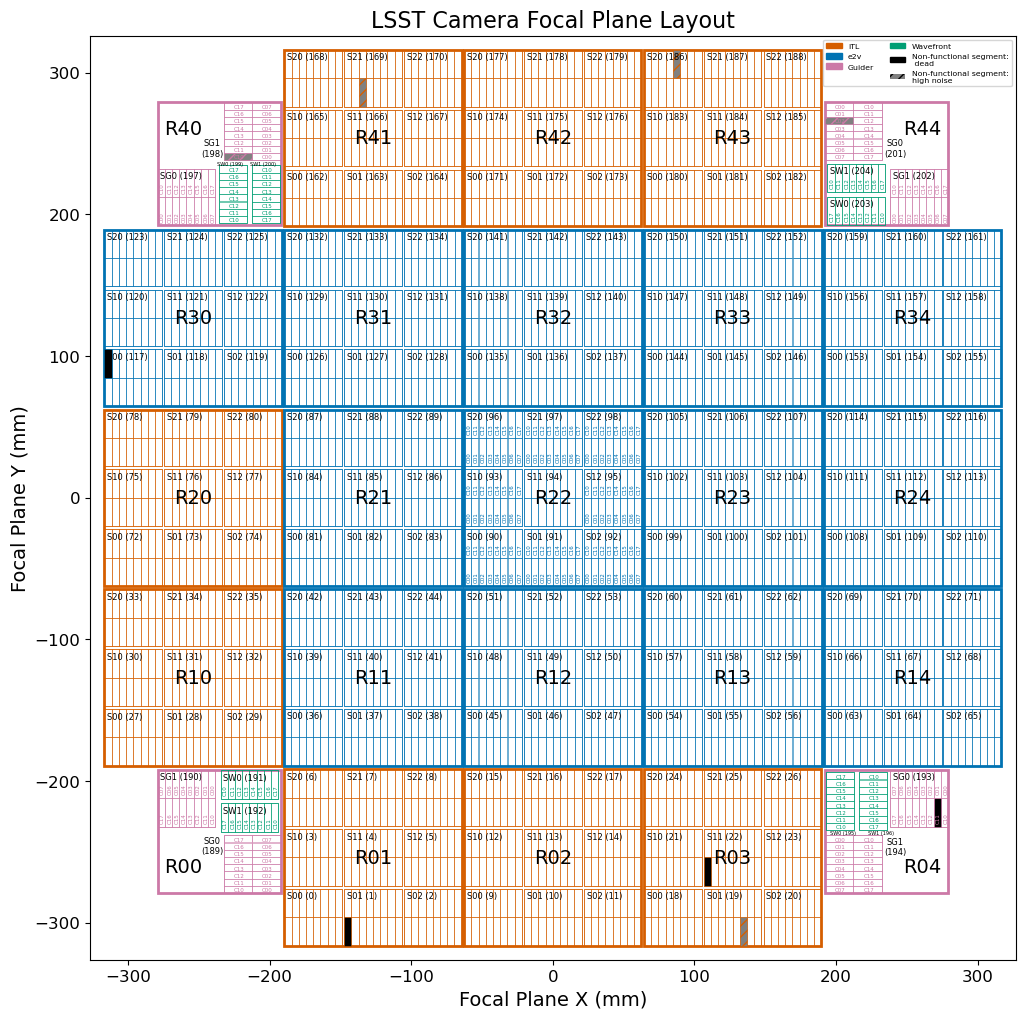

In [74]:
plot_lsst_focal_plane()